# Класифікація обʼєктів новобудови за текстовим описом за допомогою зворотної нейронної мережі

https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from translitua import translit
from googletrans import Translator

## Завантаження набору даних

In [178]:
df = pd.read_csv('./translated-1677270280197.csv', usecols=['residence', 'developer', 'price', 'attributes/class', 'description'])

In [179]:
df.head()

,residence,developer,attributes/class,description,price
0,ЖК Greenville на Печерську,Greenville,бізнес,Greenville is a combination of residential spa...,4138800.0
1,Linden Luxury Residences,Budhouse Group,преміум,The location of Linden Luxury Residences is th...,1709400.0
2,БФК OLEGIVSKIY,DIM,бізнес,OLEGIVSKIY is an exclusive business class mult...,3856325.0
3,ЖК Новий Автограф,DIM,комфорт,"Between both buildings of the ""New Autograph"" ...",3269700.0
4,NaN,NaN,NaN,NaN,NaN


In [180]:
df.shape

(100, 5)

In [181]:
df = df.dropna(subset=['attributes/class', 'description'])

In [182]:
df['attributes/class'].unique()

array(['бізнес', 'преміум', 'комфорт', 'економ'], dtype=object)

In [183]:
df.head()

,residence,developer,attributes/class,description,price
0,ЖК Greenville на Печерську,Greenville,бізнес,Greenville is a combination of residential spa...,4138800.0
1,Linden Luxury Residences,Budhouse Group,преміум,The location of Linden Luxury Residences is th...,1709400.0
2,БФК OLEGIVSKIY,DIM,бізнес,OLEGIVSKIY is an exclusive business class mult...,3856325.0
3,ЖК Новий Автограф,DIM,комфорт,"Between both buildings of the ""New Autograph"" ...",3269700.0
5,БФК А136 Highlight Tower,DIM,бізнес,Residential complex A136 Highlight Tower is a ...,6635250.0


In [184]:
df['class'] = df['attributes/class'].map({ 'бізнес': 1, 'преміум': 2, 'комфорт': 3, 'економ': 4 })

In [185]:
df = df[['description', 'class']]

In [186]:
df.head()

,description,class
0,Greenville is a combination of residential spa...,1
1,The location of Linden Luxury Residences is th...,2
2,OLEGIVSKIY is an exclusive business class mult...,1
3,"Between both buildings of the ""New Autograph"" ...",3
5,Residential complex A136 Highlight Tower is a ...,1


### Переклад на англійську

In [187]:
# translator = Translator()

In [188]:
# df = df.sample(n=6)

In [189]:
# df

In [190]:
# list(map(lambda d: len(d), list(df['description'].values)))

In [191]:
# df['description'] = df['description'].str.slice(0, 100)

In [192]:
# df['description'] = df['description'].map(lambda description: (translator.translate(description).text))

In [193]:
df

,description,class
0,Greenville is a combination of residential spa...,1
1,The location of Linden Luxury Residences is th...,2
2,OLEGIVSKIY is an exclusive business class mult...,1
3,"Between both buildings of the ""New Autograph"" ...",3
5,Residential complex A136 Highlight Tower is a ...,1
...,...,...
91,The offer to buy an apartment in the residenti...,3
93,Obolon Residences is a modern premium-class re...,2
94,Kub29 is a unique project with non-standard cu...,3
95,"""Italian quarter 2"" is a low-rise residential ...",3


## Підготовка даних для тренування моделі

### Створення сету характеристик і міток

TODO: використання imblearn.oversampling -> RandomOverSampler для прирівнювання к-сті зразків певного класу

In [194]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [195]:
train.shape, val.shape, test.shape

((70, 2), (9, 2), (9, 2))

In [196]:
df.head()

,description,class
0,Greenville is a combination of residential spa...,1
1,The location of Linden Luxury Residences is th...,2
2,OLEGIVSKIY is an exclusive business class mult...,1
3,"Between both buildings of the ""New Autograph"" ...",3
5,Residential complex A136 Highlight Tower is a ...,1


In [197]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  dataframe = dataframe.copy()
  labels = dataframe.pop('class')
  df = dataframe['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [198]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [199]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

In [200]:
hub_layer = hub.KerasLayer(embed, dtype=tf.string, trainable=True)

In [201]:
# hub_layer(list(train_data)[0][0]['description'])

In [202]:
model = Sequential()

model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [203]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [204]:
model.evaluate(train_data)

1/1 [==============================] - 0s 279ms/step - loss: 1.0408 - accuracy: 0.0000e+00


[1.0408344268798828, 0.0]

In [205]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.0408 - accuracy: 0.0000e+00 - val_loss: 0.8273 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 937ms/step - loss: 0.9022 - accuracy: 0.0429 - val_loss: 0.7341 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 929ms/step - loss: 0.7750 - accuracy: 0.1000 - val_loss: 0.6579 - val_accuracy: 0.1111
Epoch 4/10
1/1 [==============================] - 1s 832ms/step - loss: 0.6649 - accuracy: 0.1857 - val_loss: 0.5789 - val_accuracy: 0.2222
Epoch 5/10
1/1 [==============================] - 1s 808ms/step - loss: 0.5592 - accuracy: 0.2429 - val_loss: 0.4949 - val_accuracy: 0.3333
Epoch 6/10
1/1 [==============================] - 1s 777ms/step - loss: 0.4488 - accuracy: 0.2714 - val_loss: 0.4054 - val_accuracy: 0.3333
Epoch 7/10
1/1 [==============================] - 1s 789ms/step - loss: 0.3358 - accuracy: 0.2714 - val_loss: 0.3089 - val_accuracy: 0.3333
Epoch 8/10


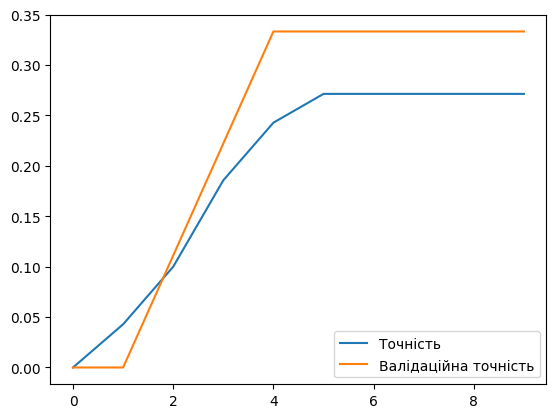

In [209]:
plt.plot(history.history['accuracy'], label="Точність")
plt.plot(history.history['val_accuracy'], label="Валідаційна точність")
plt.legend()

plt.show()

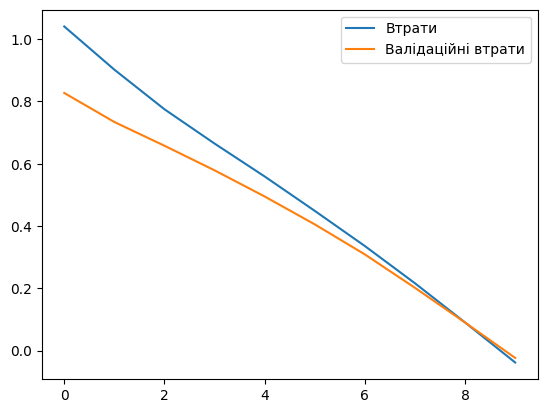

In [210]:
plt.plot(history.history['loss'], label="Втрати")
plt.plot(history.history['val_loss'], label="Валідаційні втрати")
plt.legend()

plt.show()

In [208]:
model.evaluate(test_data)

1/1 [==============================] - 0s 132ms/step - loss: -0.0720 - accuracy: 0.3333


[-0.0720483586192131, 0.3333333432674408]

TODO: also use LSTM https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org